![](https://i.ibb.co/3vF9yD8/Screenshot-from-2019-05-29-21-23-47.png)

**MNIST ("Modified National Institute of Standards and Technology")** is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.


In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
kaggle.json


In [ ]:
!kaggle competitions download -c digit-recognizer -p /content/drive/My\Drive/kaggle/digit-recognizer

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import pandas as pd
import numpy as np


from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style ('darkgrid')
%matplotlib inline
np.random.seed(42)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/digit-recognizer/train.csv.zip')

In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/kaggle/digit-recognizer/test.csv.zip')

In [ ]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = train.drop('label', axis=1)

In [ ]:
target = train['label']

In [ ]:
X = np.array(features)

In [ ]:
X_test = np.array(test)

In [ ]:
X_train = X.reshape(X.shape[0], 28, 28)

In [ ]:
X_train.shape

(42000, 28, 28)

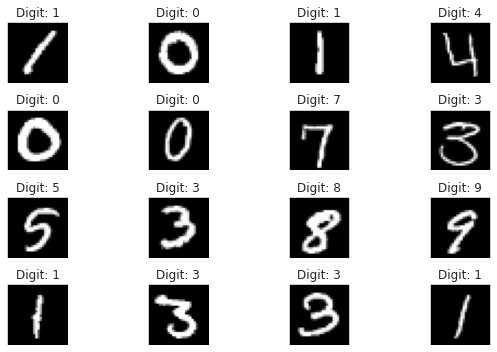

In [ ]:
fig = plt.figure(figsize=(10,5))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    
    plt.imshow(X_train[i], cmap='gray')
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Digit: ' + str(target[i]))


In [ ]:
target.value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

In [ ]:
len(target.value_counts())

10

In [ ]:
X_train = X.reshape(X.shape[0], 28, 28, 1)
X_test_reshape = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, target, test_size=0.25, random_state=42)

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 64, 
                 kernel_size = (5,5), 
                 padding = 'same', 
                 activation ='elu', 
                 input_shape = (28,28,1)))

model.add(BatchNormalization())

model.add(Conv2D(filters = 64, 
                 kernel_size = (5,5), 
                 padding = 'same', 
                 activation ='elu'))

model.add(BatchNormalization())

model.add(AvgPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 padding = 'same', 
                 activation ='elu'))

model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'same', 
                 activation ='elu'))
model.add(BatchNormalization())

model.add(AvgPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 padding = 'same',  
                 activation ='elu'))

model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation = "softmax"))

optimizer = Nadam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

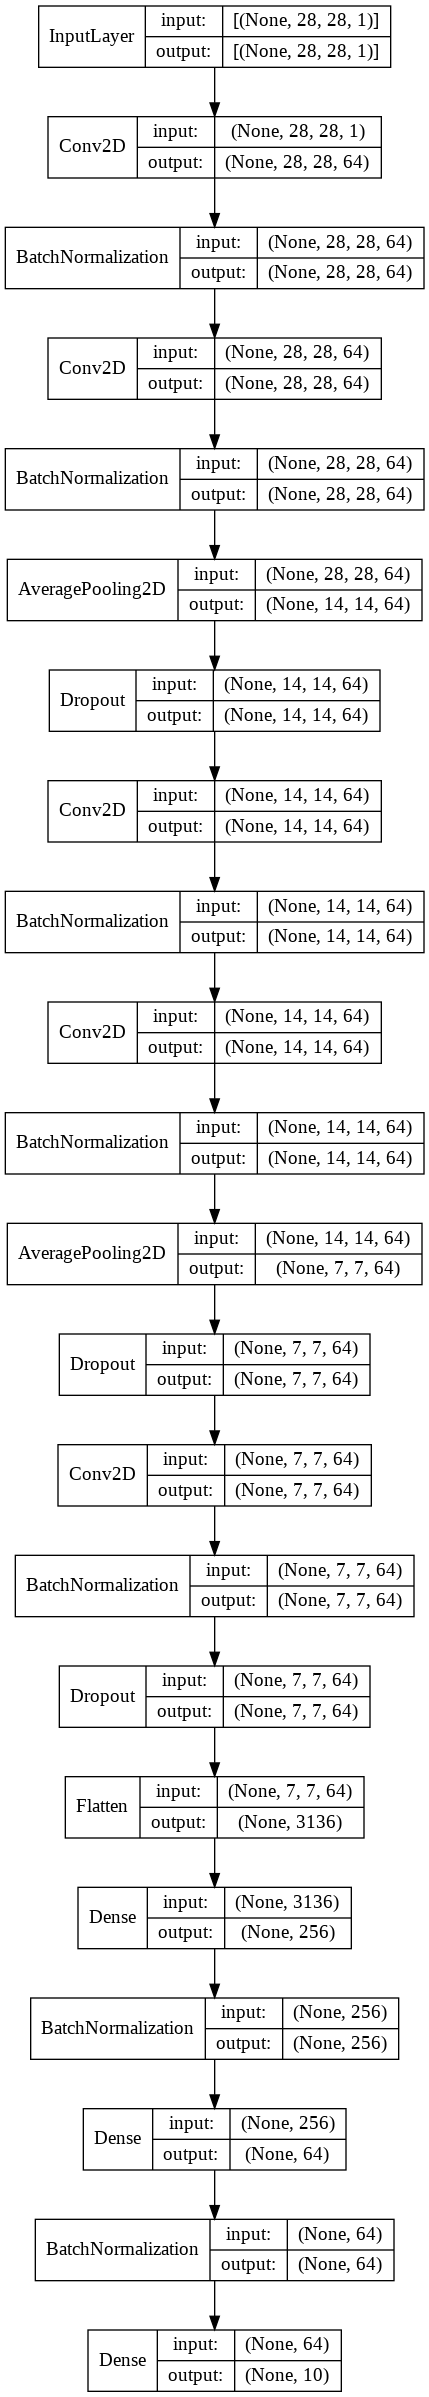

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.0002,
    mode='min', 
    patience=3,
    restore_best_weights=True,
)

Epoch 1/42
1969/1969 [==============================] - 44s 20ms/step - loss: 0.2957 - acc: 0.9143 - val_loss: 0.0894 - val_acc: 0.9745
Epoch 2/42
1969/1969 [==============================] - 39s 20ms/step - loss: 0.1080 - acc: 0.9700 - val_loss: 0.0422 - val_acc: 0.9873
Epoch 3/42
1969/1969 [==============================] - 37s 19ms/step - loss: 0.0767 - acc: 0.9788 - val_loss: 0.0406 - val_acc: 0.9874
Epoch 4/42
1969/1969 [==============================] - 36s 18ms/step - loss: 0.0614 - acc: 0.9824 - val_loss: 0.0324 - val_acc: 0.9906
Epoch 5/42
1969/1969 [==============================] - 36s 18ms/step - loss: 0.0512 - acc: 0.9850 - val_loss: 0.0267 - val_acc: 0.9917
Epoch 6/42
1969/1969 [==============================] - 36s 18ms/step - loss: 0.0433 - acc: 0.9872 - val_loss: 0.0263 - val_acc: 0.9918
Epoch 7/42
1969/1969 [==============================] - 37s 19ms/step - loss: 0.0391 - acc: 0.9885 - val_loss: 0.0287 - val_acc: 0.9911
Epoch 8/42
1969/1969 [==========================

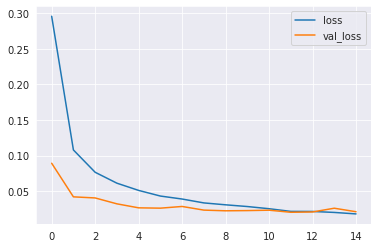

In [ ]:
history = model.fit(X_tr, y_tr, 
          validation_data=(X_val, y_val),
          verbose=1, epochs=42, batch_size=16,
          callbacks=early_stopping)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
X_test_reshape.shape

(28000, 28, 28, 1)

In [ ]:
preds = np.argmax(model.predict(X_test_reshape), axis=1)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/kaggle/digit-recognizer/sample_submission.csv')

In [ ]:
submission.shape

(28000, 2)

In [ ]:
submission['Label'] = preds
submission.to_csv('my_submission_keras.csv',index=False)
files.download("my_submission_keras.csv")

submission.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


public score: **0.99296**